In [2]:
from chromatic_fitting import *
import celerite2
from celerite2.theano import terms, GaussianProcess

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running chromatic_fitting v0.12.11!

This program is running on:
Python v3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) 
[Clang 15.0.7 ]
numpy v1.21.6
chromatic v0.4.7
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


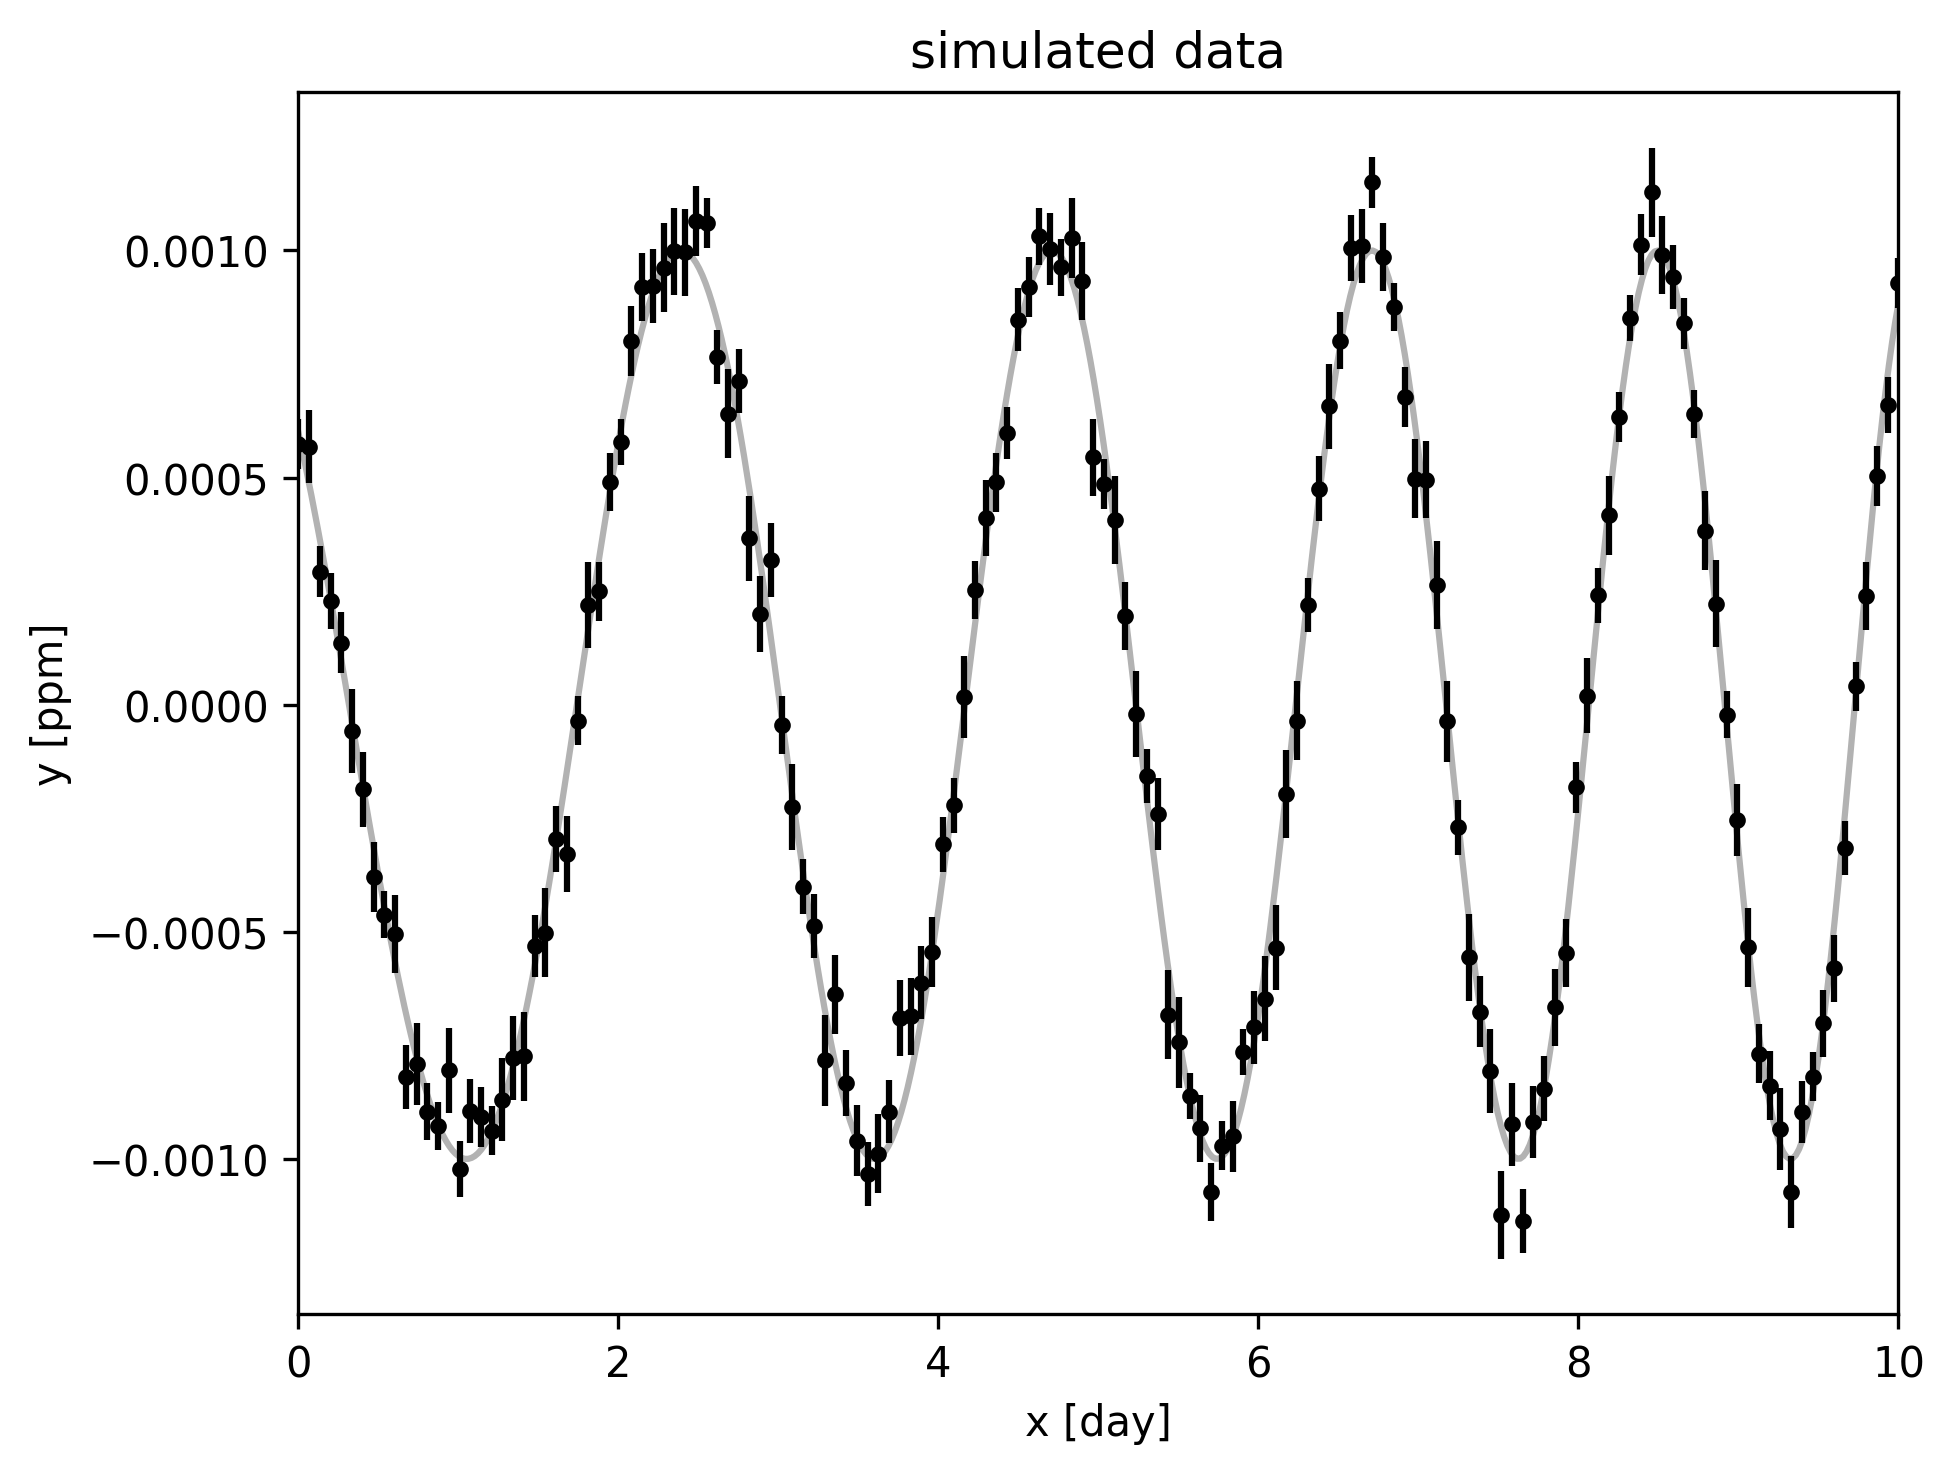

In [166]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(43)

# t = np.sort(
#     np.append(
#         np.random.uniform(0, 3.8, 57),
#         np.random.uniform(5.5, 10, 68),
#     )
# )  # The input coordinates must be sorted
t = np.linspace(0, 10, 150)
yerr = np.random.uniform(0.05, 0.1, len(t))
y = (
    # 0.2 * (t - 5)
    np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 500)
# true_y = 0.2 * (true_t - 5) + 
true_y = np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y/1e3, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y/1e3, yerr=yerr/1e3, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

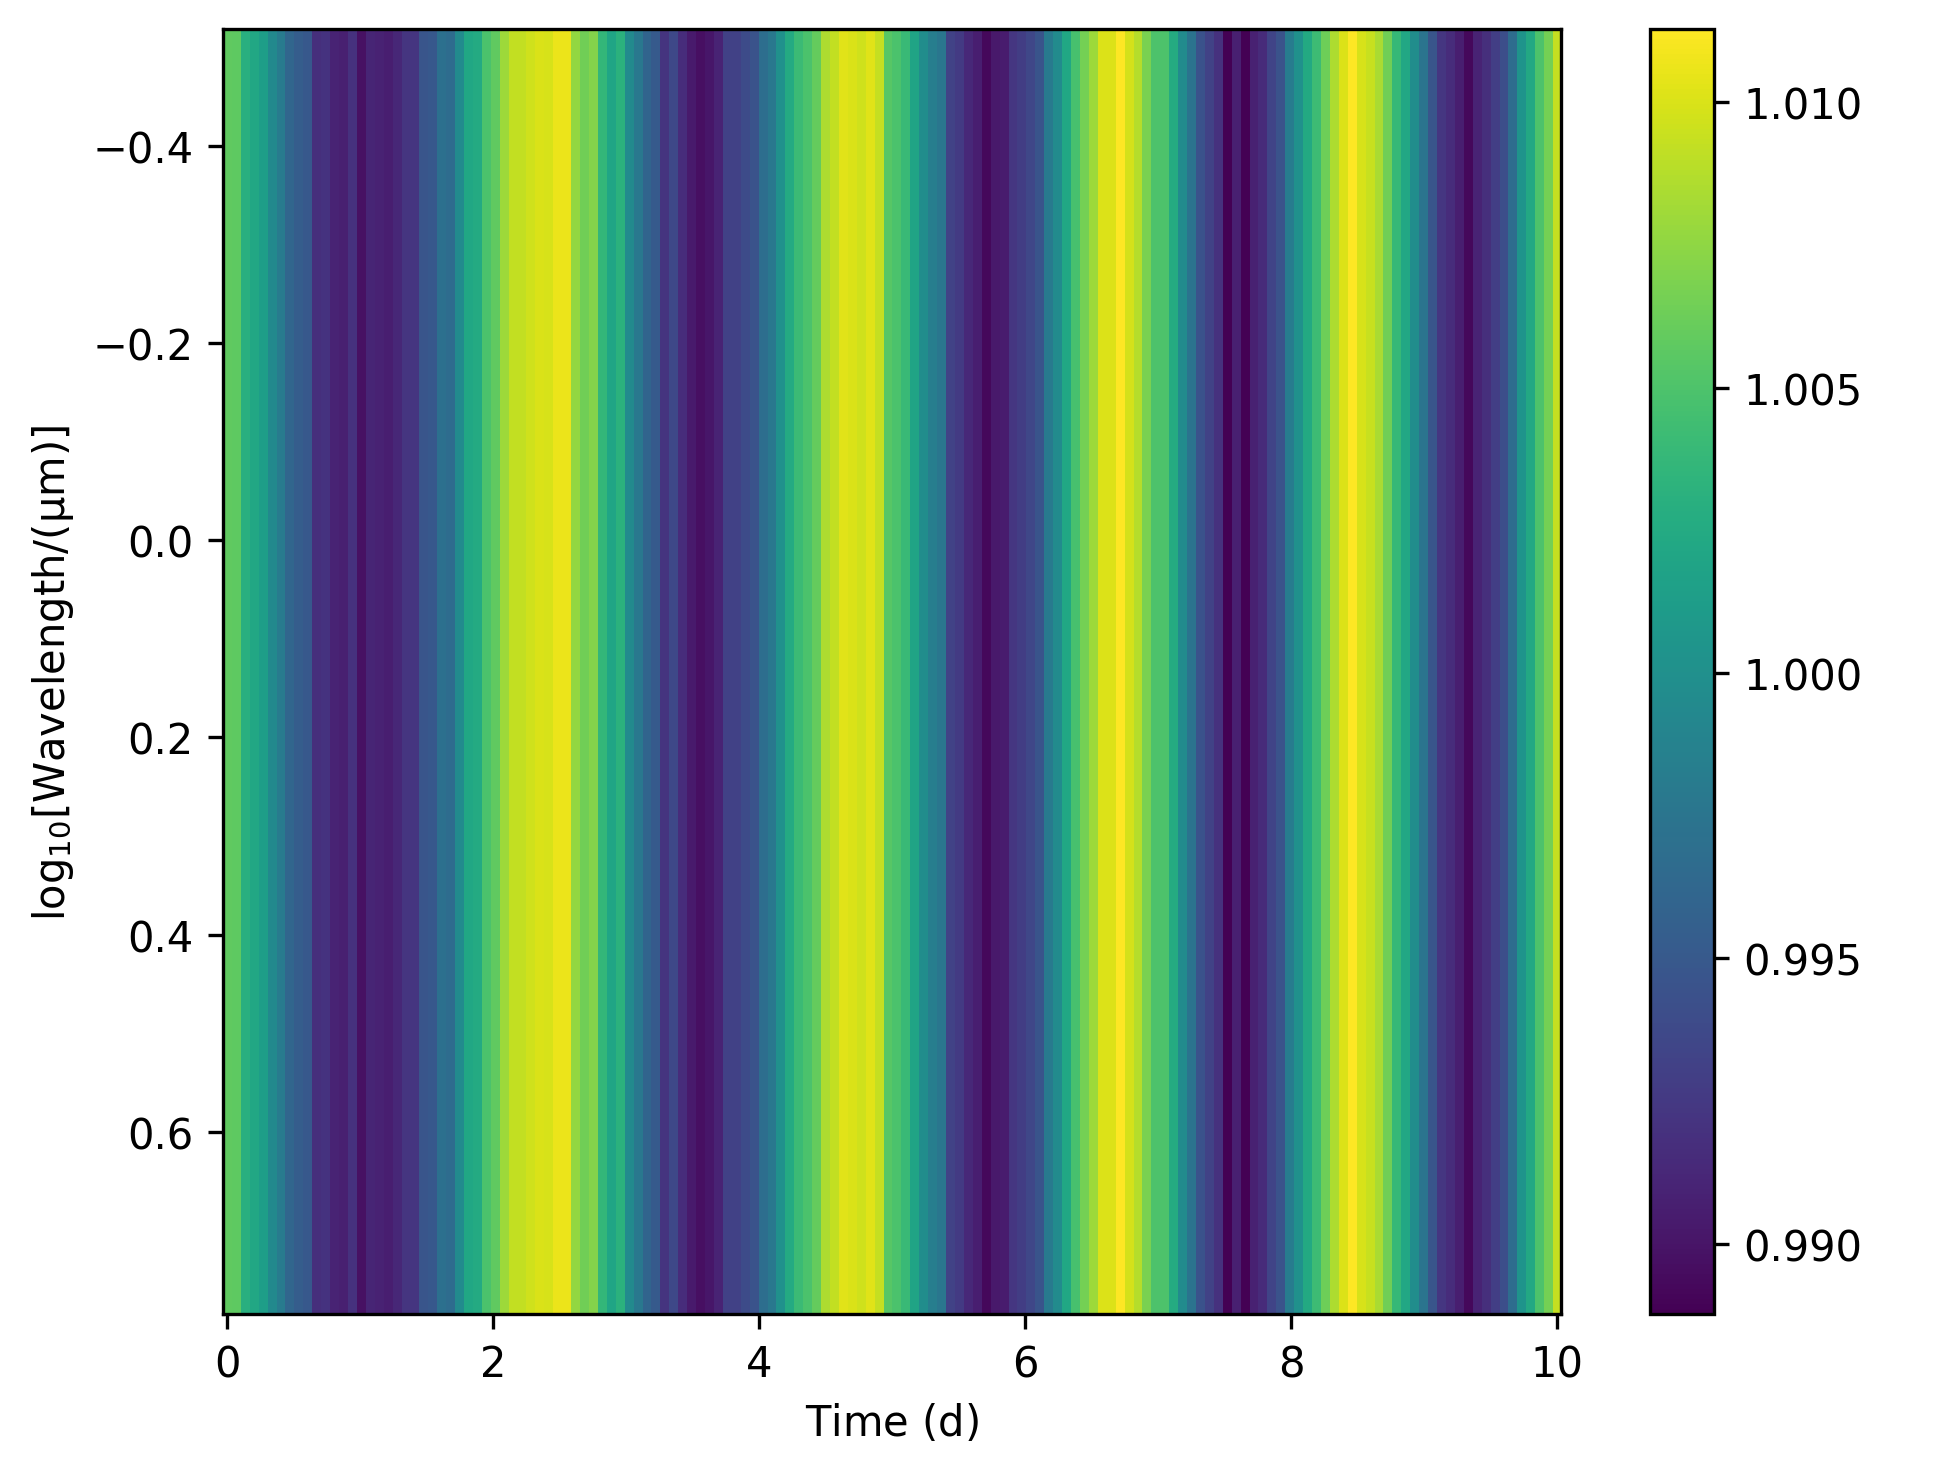

In [167]:
r = SimulatedRainbow(time=t*u.day, R=1)
r.flux *= 1+(y/1e2)
r.uncertainty[:,:] = yerr/1e2
r.imshow()

In [168]:
r

<Simulated🌈(3w, 150t)>

In [169]:
r = r.inject_transit(planet_radius=0.1,t0=1.7,per=10)

In [172]:
r.flux = r.flux - 1

(-0.1, 0.02)

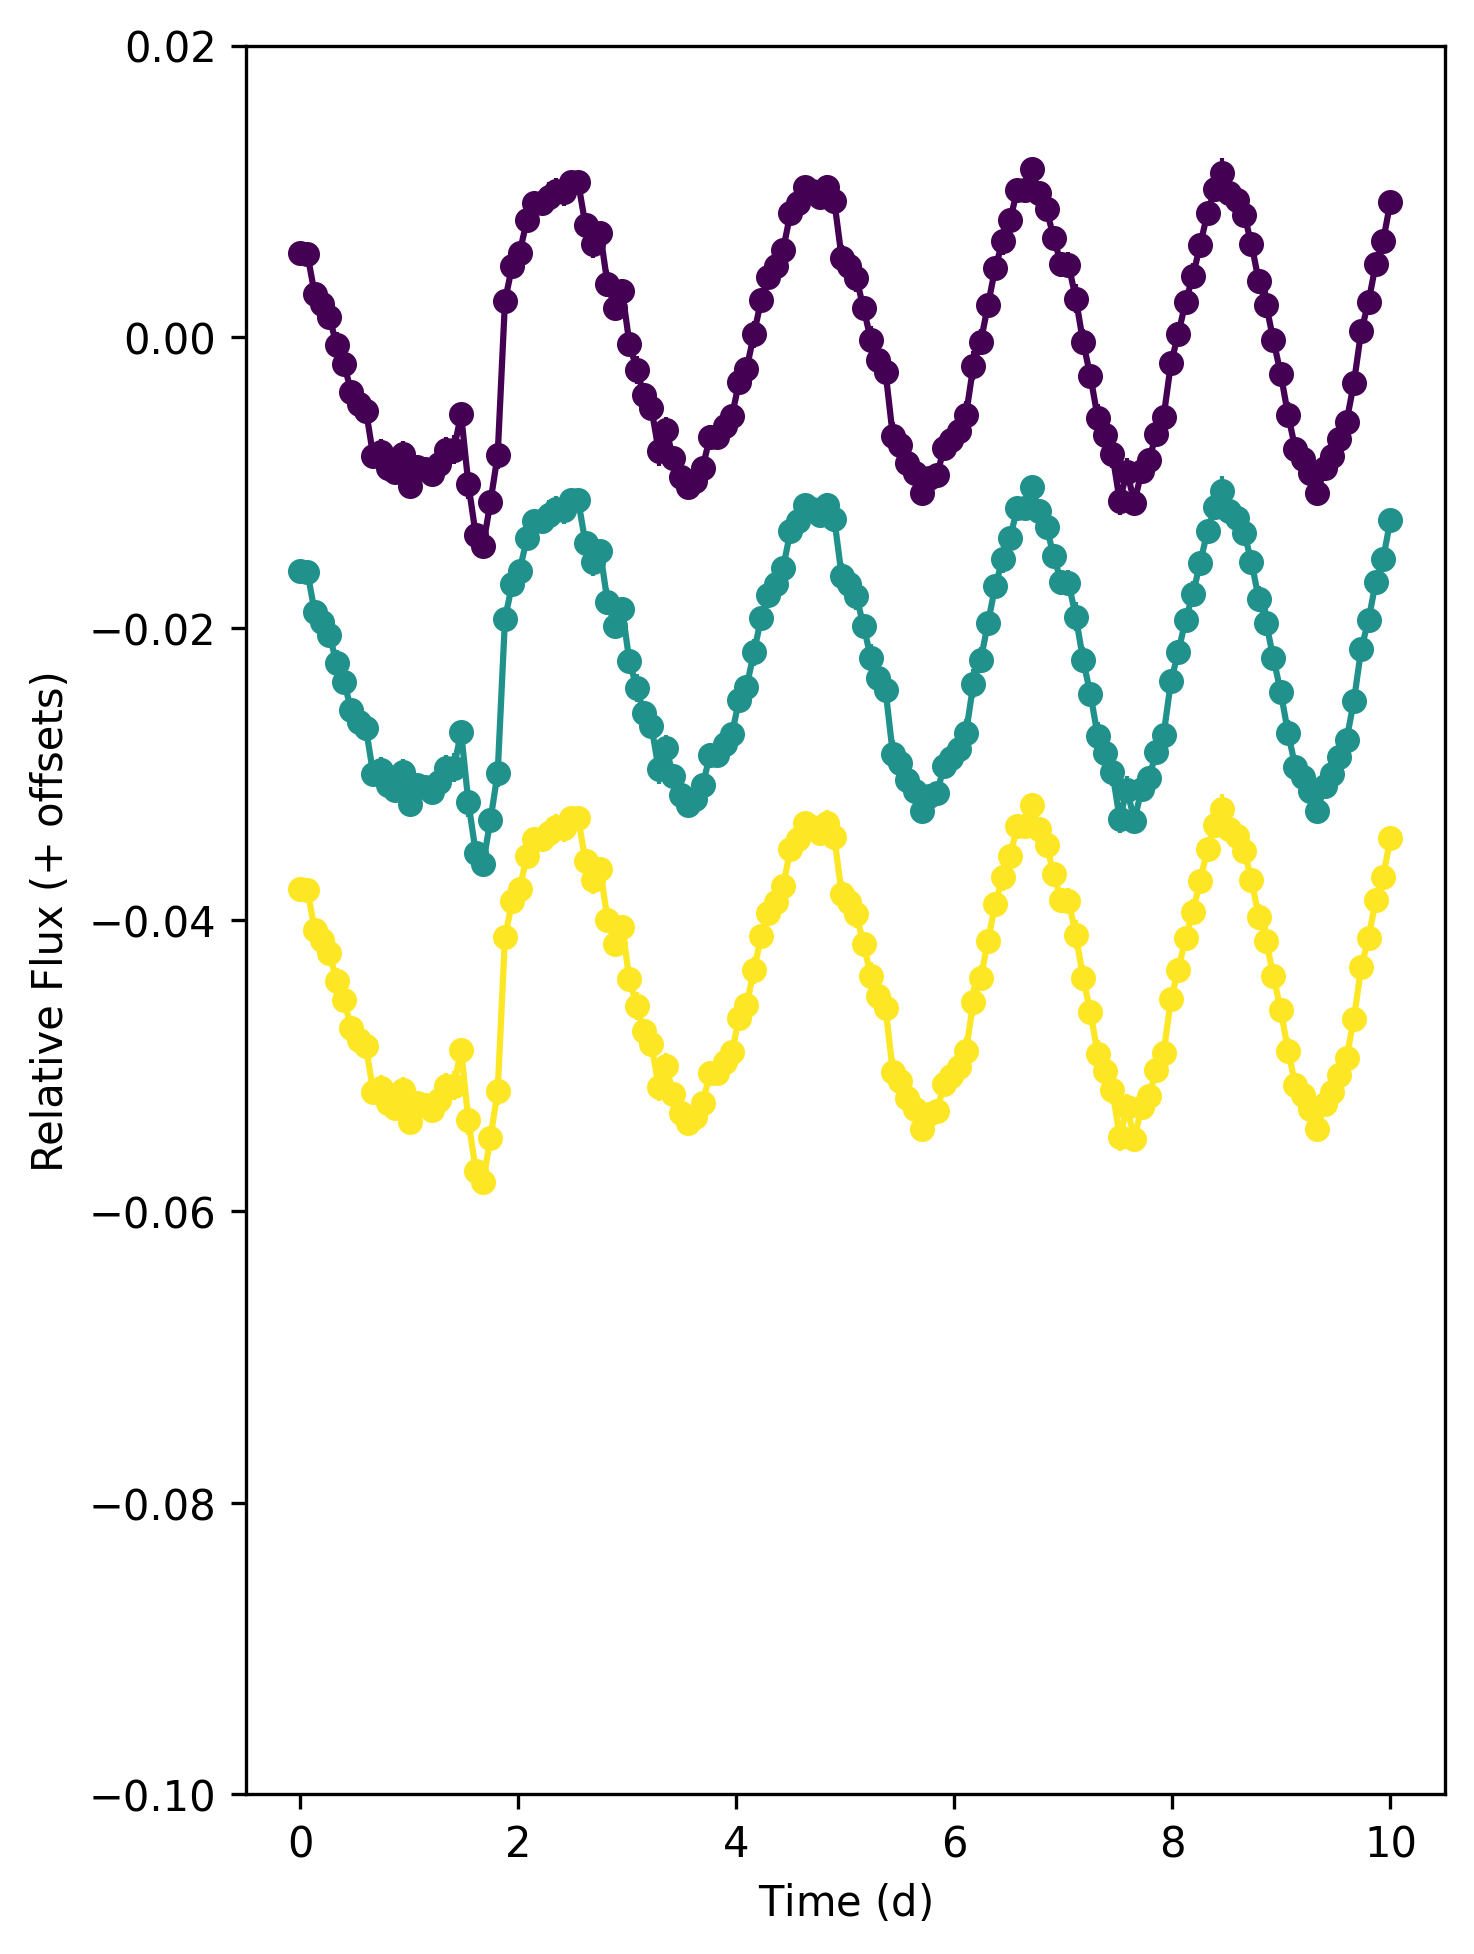

In [174]:
r.plot_lightcurves(text=False)
plt.ylim(-0.1,0.02)

In [175]:
# opt

In [176]:
# set up polynomial model:
p1 = GPModel(kernel='sho', name='periodic')

p1.setup_parameters(
    sigma = WavelikeFitted(Normal,mu=2, sigma=5),
    rho = Fitted(Normal,mu=2, sigma=5),
    tau = Fitted(Normal,mu=10, sigma=5),
)
p1.summarize_parameters()

# print a summary of all params:
# p1.summarize_parameters()

periodic_sigma =
  <🧮 WavelikeFitted Normal(mu=2, sigma=5, name='periodic_sigma') for each wavelength 🧮>

periodic_rho =
  <🧮 Fitted Normal(mu=2, sigma=5, name='periodic_rho') 🧮>

periodic_tau =
  <🧮 Fitted Normal(mu=10, sigma=5, name='periodic_tau') 🧮>



In [193]:
# set up polynomial model:
# p2 = GPModel(kernel='sho', name='nonperiodic')

# p2.setup_parameters(
#     sigma = Fitted(Normal,mu=1, sigma=100),
#     rho = Fitted(Normal,mu=1, sigma=100),
#     Q = 0.25,
# )

# # print a summary of all params:
# p2.summarize_parameters()
# p2 = PolynomialModel(degree=1,)
# p2.setup_parameters(
#     p_0=Fitted(Normal, mu=0, sigma=0.1),
#     p_1=Fitted(Normal, mu=1/5000, sigma=0.1),
# )
# p2.summarize_parameters()

from exoplanet.distributions import ImpactParameter
tr = TransitModel()
tr.setup_parameters(
                  period=10, # a fixed value!
                   epoch=Fitted(Uniform,lower=1.5,upper=2, testval=1.75), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1.0),
                   stellar_mass = 1,
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05), # a different value fitted for every wavelength!
                   impact_parameter=Fitted(ImpactParameter,ror=0.1,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.2,0.2], shape=2),
                   baseline = 0 #WavelikeFitted(Normal, mu=0.0, sigma=0.05), 
                )
tr.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1.0, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fixed | 1 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 10 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=1.5, upper=2, testval=1.75, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Fixed | 0 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.1, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 0 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted Uniform(testval=[0.2, 0.2], shape=2, name='transit_limb_darkening') for each wavelength 🧮>



In [194]:
p = p1 + tr

In [195]:
p

<chromatic combined model 'combined' 🌈, models: <chromatic GP model 'periodic', with sho kernel 🌈> + <chromatic transit model 'transit' 🌈>

In [196]:
p.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

periodic_sigma =
  <🧮 WavelikeFitted Normal(mu=2, sigma=5, name='periodic_sigma') for each wavelength 🧮>

periodic_rho =
  <🧮 Fitted Normal(mu=2, sigma=5, name='periodic_rho') 🧮>

periodic_tau =
  <🧮 Fitted Normal(mu=10, sigma=5, name='periodic_tau') 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1.0, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fixed | 1 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 10 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=1.5, upper=2, testval=1.75, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Fixed | 0 🧮>

transit_impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.1, testval=0.44, name='transit_impact_parameter') 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 0 🧮>

tra

In [197]:
p.attach_data(r)

In [198]:
p.add_jitter(Fitted(Normal,name='log_jitter', mu=0, sigma=3))
# p.add_mean(Fixed(1.0))

Error applying add_jitter to <chromatic transit model 'transit' 🌈>: 'TransitModel' object has no attribute 'add_jitter'


In [199]:
p.setup_lightcurves()

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/gp.py:104: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn(


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}


In [200]:
print(p._pymc3_model)

                   periodic_sigma ~ Normal
                     periodic_rho ~ Normal
                     periodic_tau ~ Normal
                       log_jitter ~ Normal
         transit_epoch_interval__ ~ TransformedDistribution
transit_impact_parameter_impact__ ~ TransformedDistribution
transit_stellar_radius_interval__ ~ TransformedDistribution
transit_limb_darkening_interval__ ~ TransformedDistribution
             transit_radius_ratio ~ Normal
                    transit_epoch ~ Uniform
         transit_impact_parameter ~ ImpactParameter
           transit_stellar_radius ~ Uniform
           transit_limb_darkening ~ Uniform
                     transit_a_R* ~ Deterministic
            transit_planet_radius ~ Deterministic


In [201]:
p.setup_likelihood()

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/combined.py:530: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn(


In [202]:
p._chromatic_models['transit'].parameters

{'transit_stellar_radius': <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1.0, name='transit_stellar_radius', shape=1) 🧮>,
 'transit_stellar_mass': <🧮 Fixed | 1 🧮>,
 'transit_radius_ratio': <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='transit_radius_ratio', shape=3) for each wavelength 🧮>,
 'transit_period': <🧮 Fixed | 10 🧮>,
 'transit_epoch': <🧮 Fitted Uniform(lower=1.5, upper=2, testval=1.75, name='transit_epoch', shape=1) 🧮>,
 'transit_baseline': <🧮 Fixed | 0 🧮>,
 'transit_impact_parameter': <🧮 Fitted ImpactParameter(ror=0.1, testval=0.44, name='transit_impact_parameter', shape=1) 🧮>,
 'transit_eccentricity': <🧮 Fixed | 0.0 🧮>,
 'transit_omega': <🧮 Fixed | 0 🧮>,
 'transit_limb_darkening': <🧮 WavelikeFitted Uniform(testval=[0.2, 0.2], shape=(3, 2), name='transit_limb_darkening') for each wavelength 🧮>}

optimizing logp for variables: [transit_limb_darkening, transit_impact_parameter, transit_epoch, transit_radius_ratio, transit_stellar_radius]


message: Optimization terminated successfully.
logp: -501.3029149783257 -> -498.5844648523763



{'periodic_sigma': array([2., 2., 2.]), 'periodic_rho': array([2.]), 'periodic_tau': array([10.]), 'log_jitter': array(0.), 'transit_epoch_interval__': array([-0.00127146]), 'transit_impact_parameter_impact__': array([-0.0002778]), 'transit_stellar_radius_interval__': array([0.00014985]), 'transit_limb_darkening_interval__': array([[-1.97984851e-05, -1.58487355e-05],
       [-1.97984839e-05, -1.58487351e-05],
       [-1.97984854e-05, -1.58487355e-05]]), 'transit_radius_ratio': array([0.0999991 , 0.09999908, 0.09999908]), 'transit_epoch': array([1.74984107]), 'transit_impact_parameter': array([0.54992361]), 'transit_stellar_radius': array([1.00001499]), 'transit_limb_darkening': array([[0.49999505, 0.49999604],
       [0.49999505, 0.49999604],
       [0.49999505, 0.49999604]]), 'transit_a_R*': array([19.53280507]), 'transit_planet_radius': array([0.1000006 , 0.10000058, 0.10000058])}


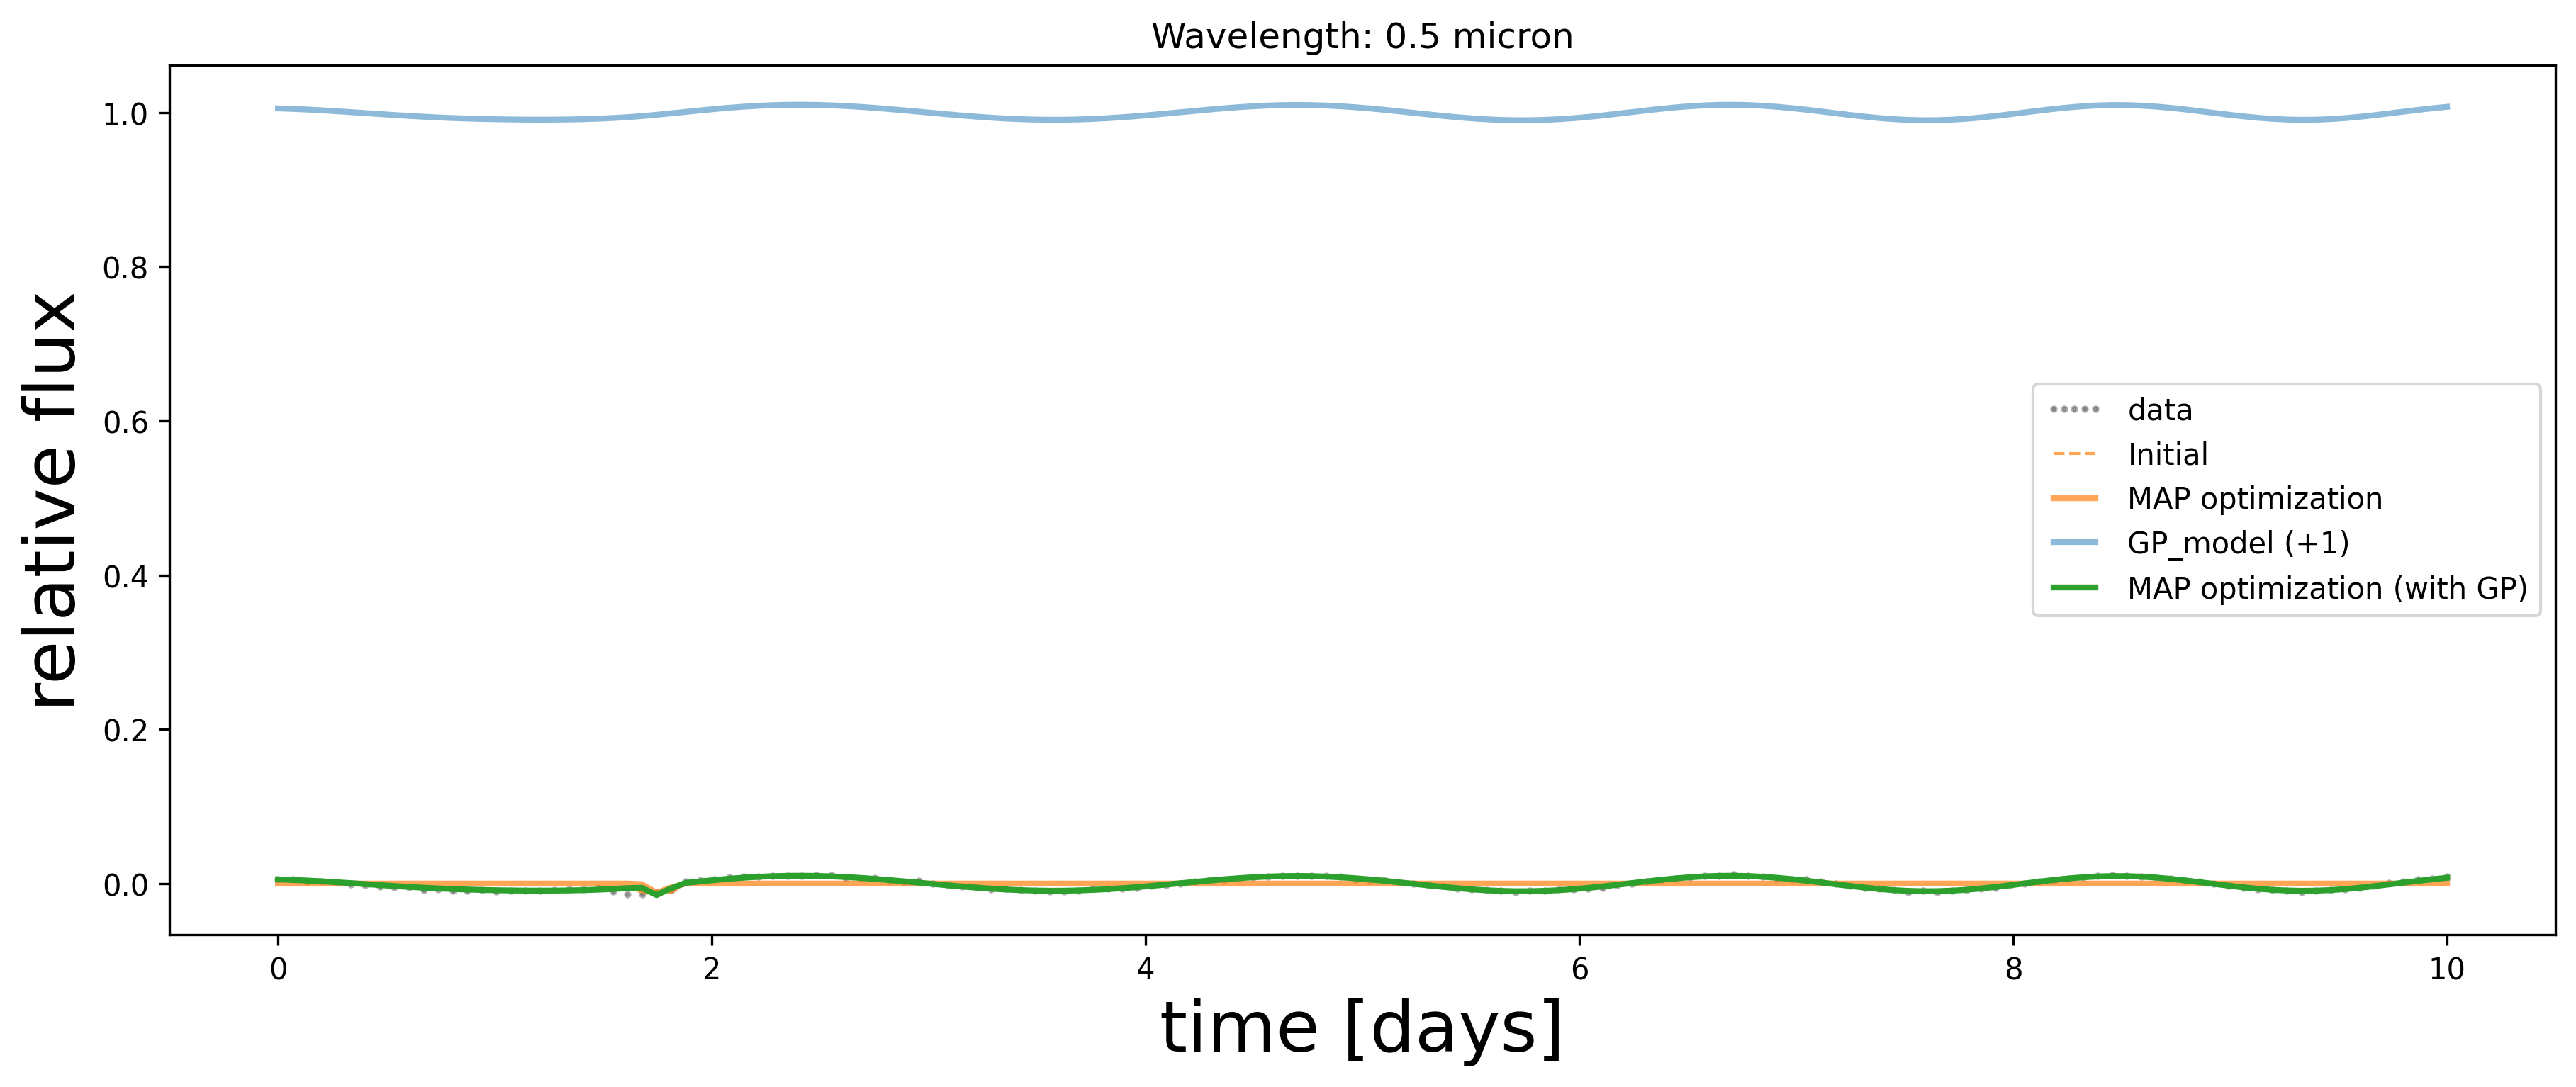

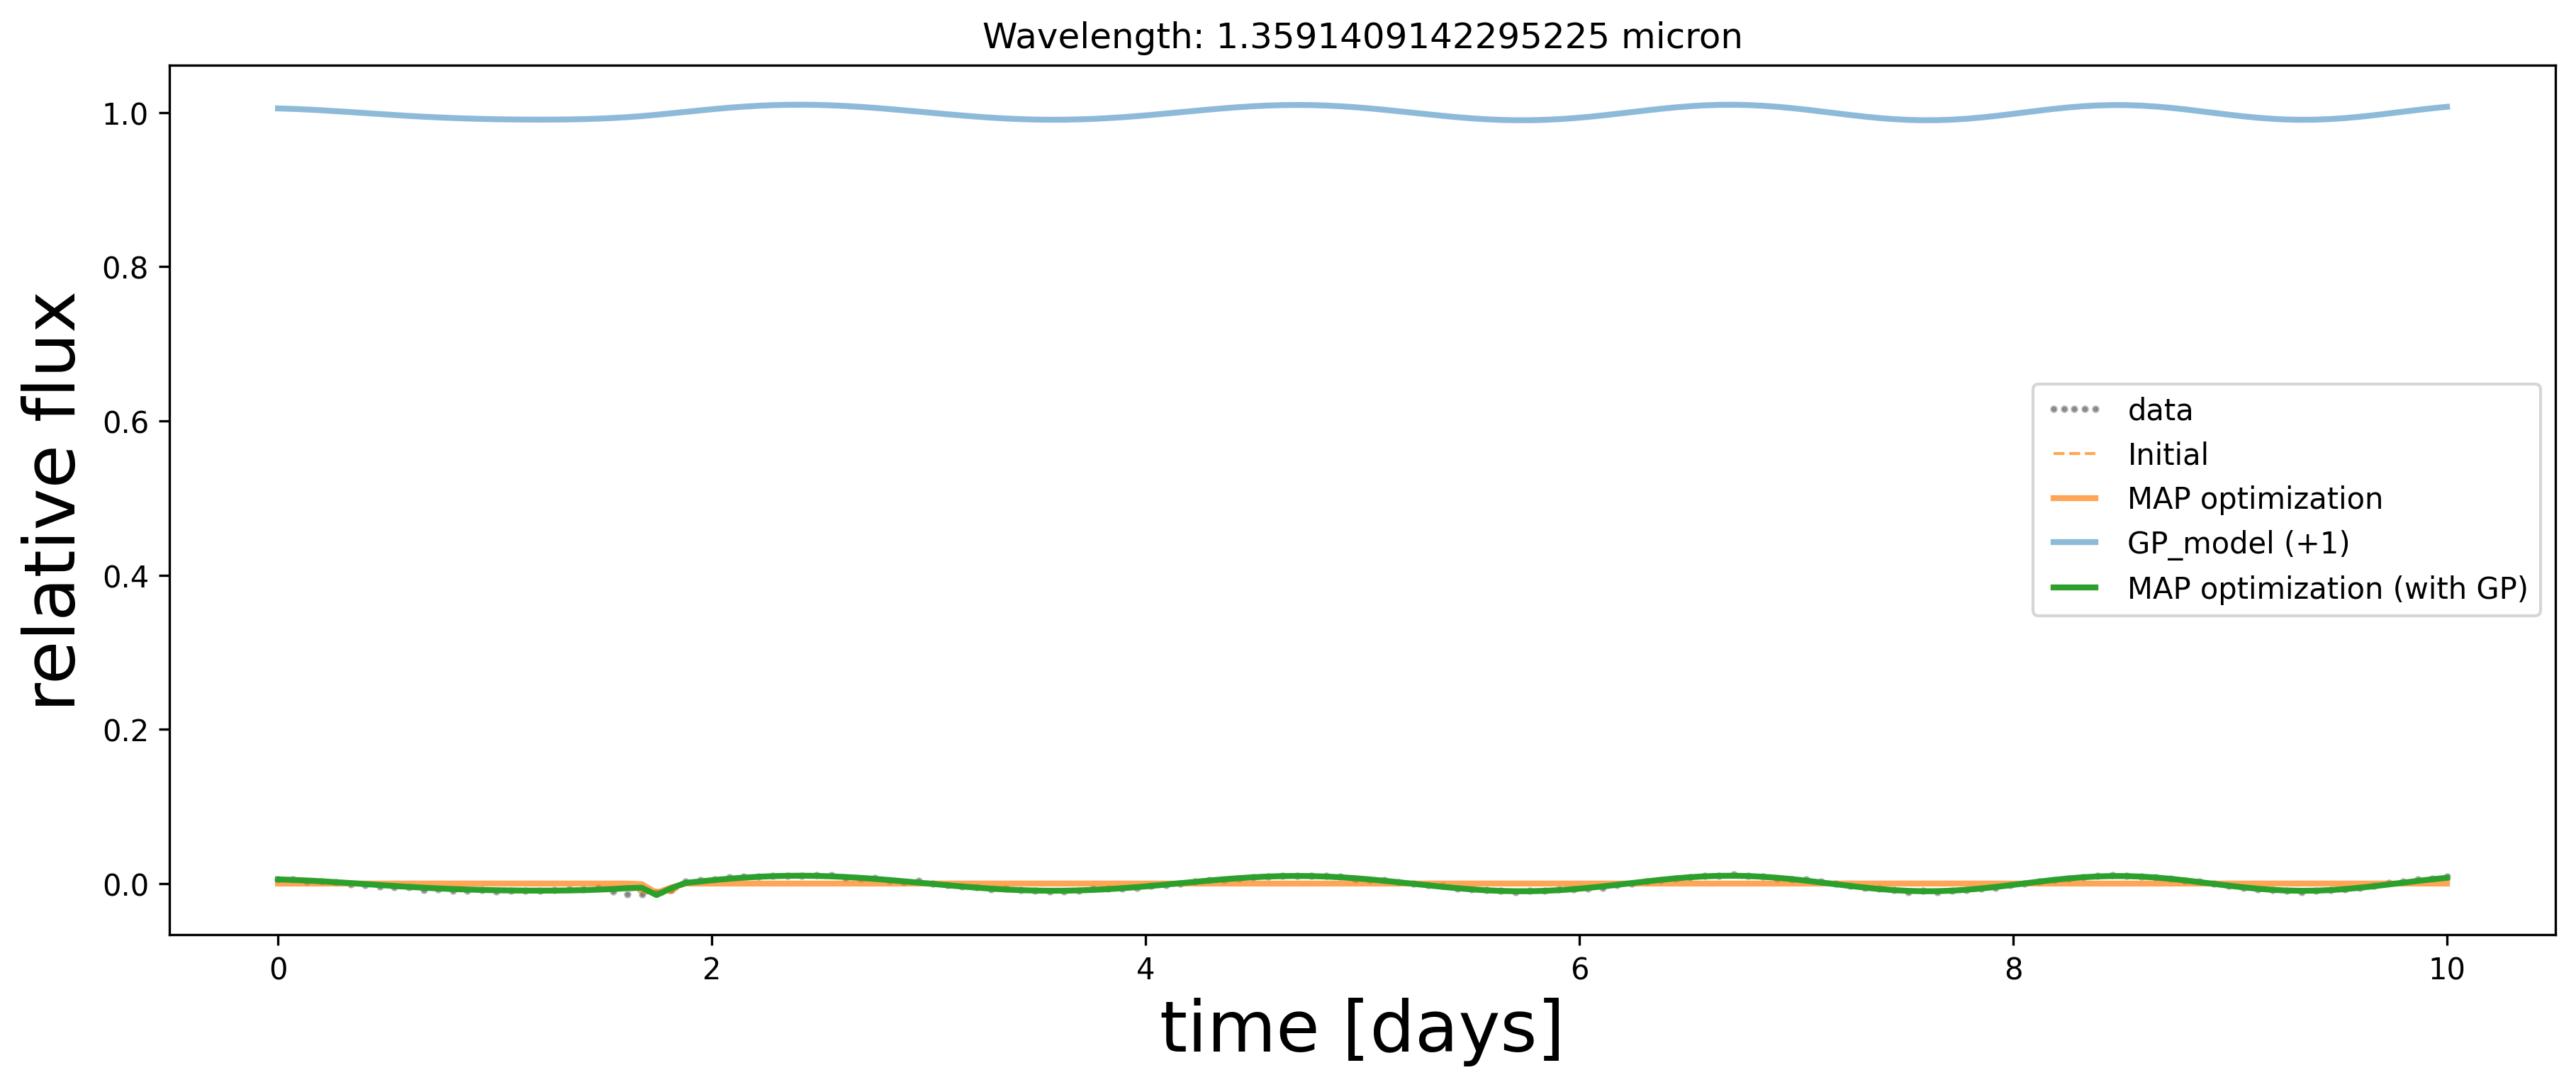

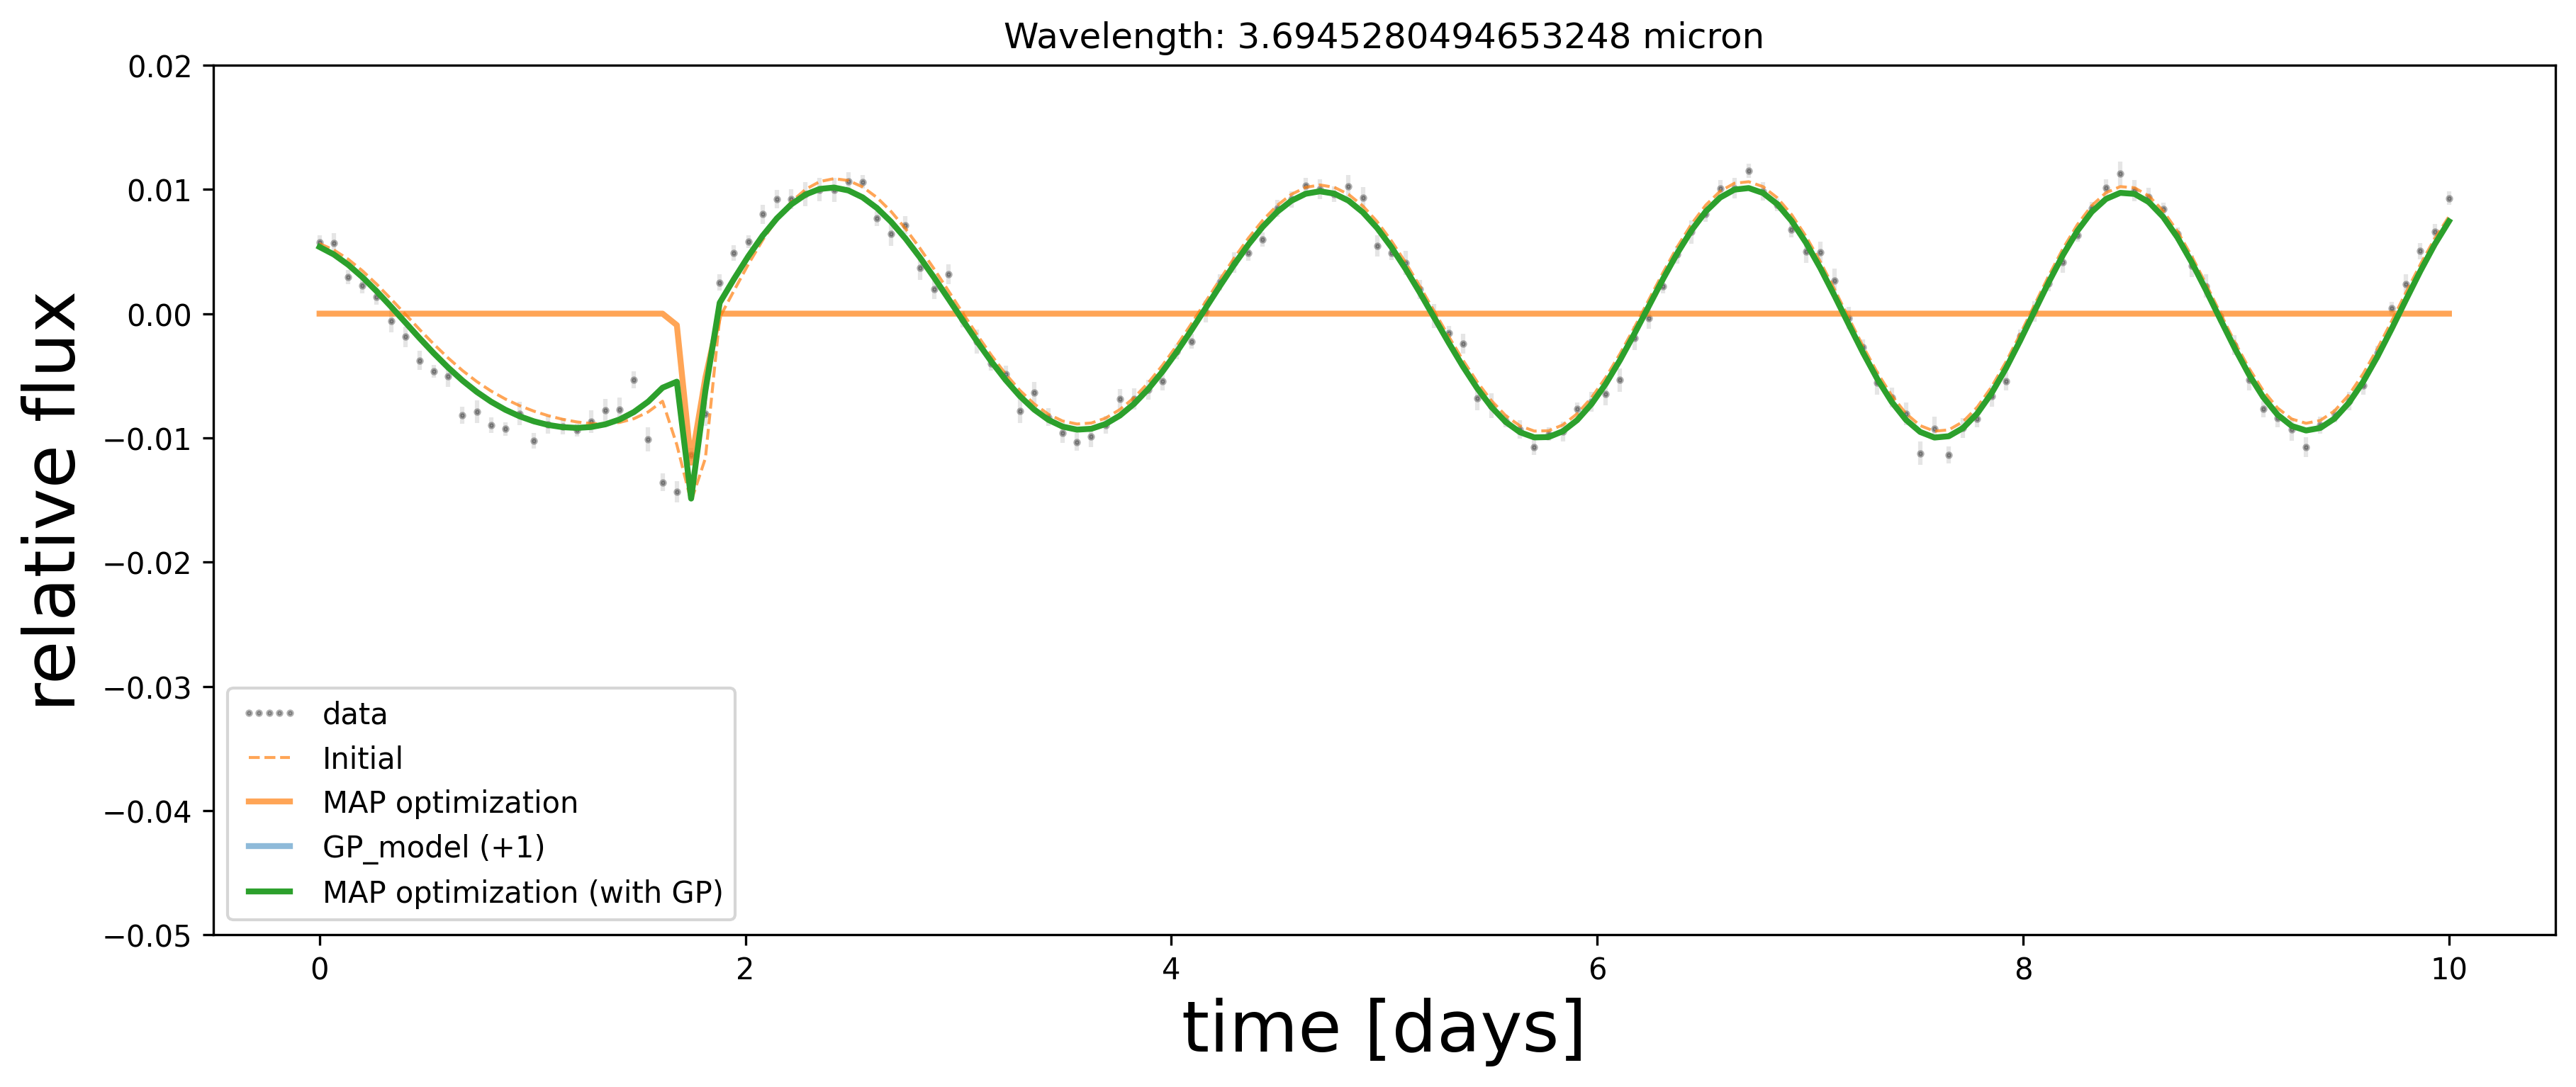

In [205]:
# optimize for initial values!
# opt = p.optimize(plot=True)
# plt.ylim(-0.02,0.02)

params_gp = p._chromatic_models['periodic'].parameters
params_tr = p._chromatic_models['transit'].parameters
map_soln = p._pymc3_model.test_point

map_soln = p.optimize( plot=True, start=map_soln, 
                          vars=[params_tr['transit_stellar_radius'].get_prior_vector(), 
                                  params_tr['transit_radius_ratio'].get_prior_vector(), 
                                  params_tr['transit_epoch'].get_prior_vector(),
                                 params_tr['transit_impact_parameter'].get_prior_vector(),
                               params_tr['transit_limb_darkening'].get_prior_vector()]
        )
plt.ylim(-0.05,0.02)
print(map_soln)

# map_soln = p.optimize(plot=True, start=map_soln,
#                       vars=[params_gp['periodic_sigma'].get_prior_vector(), 
#                                   params_gp['periodic_rho'].get_prior_vector(), 
#                                   params_gp['periodic_tau'].get_prior_vector()]
#          )
# print(map_soln)
# plt.ylim(-0.02,0.02)

gp_model = p.generate_gp_model_from_params(params=map_soln)
opt_y = eval_in_model(p.every_light_curve['wavelength_0'],model=p._pymc3_model)[0]
mu, variance = eval_in_model(gp_model.predict(p.data.flux[0] - opt_y, t=p.data.time, return_var=True), model=p._pymc3_model)

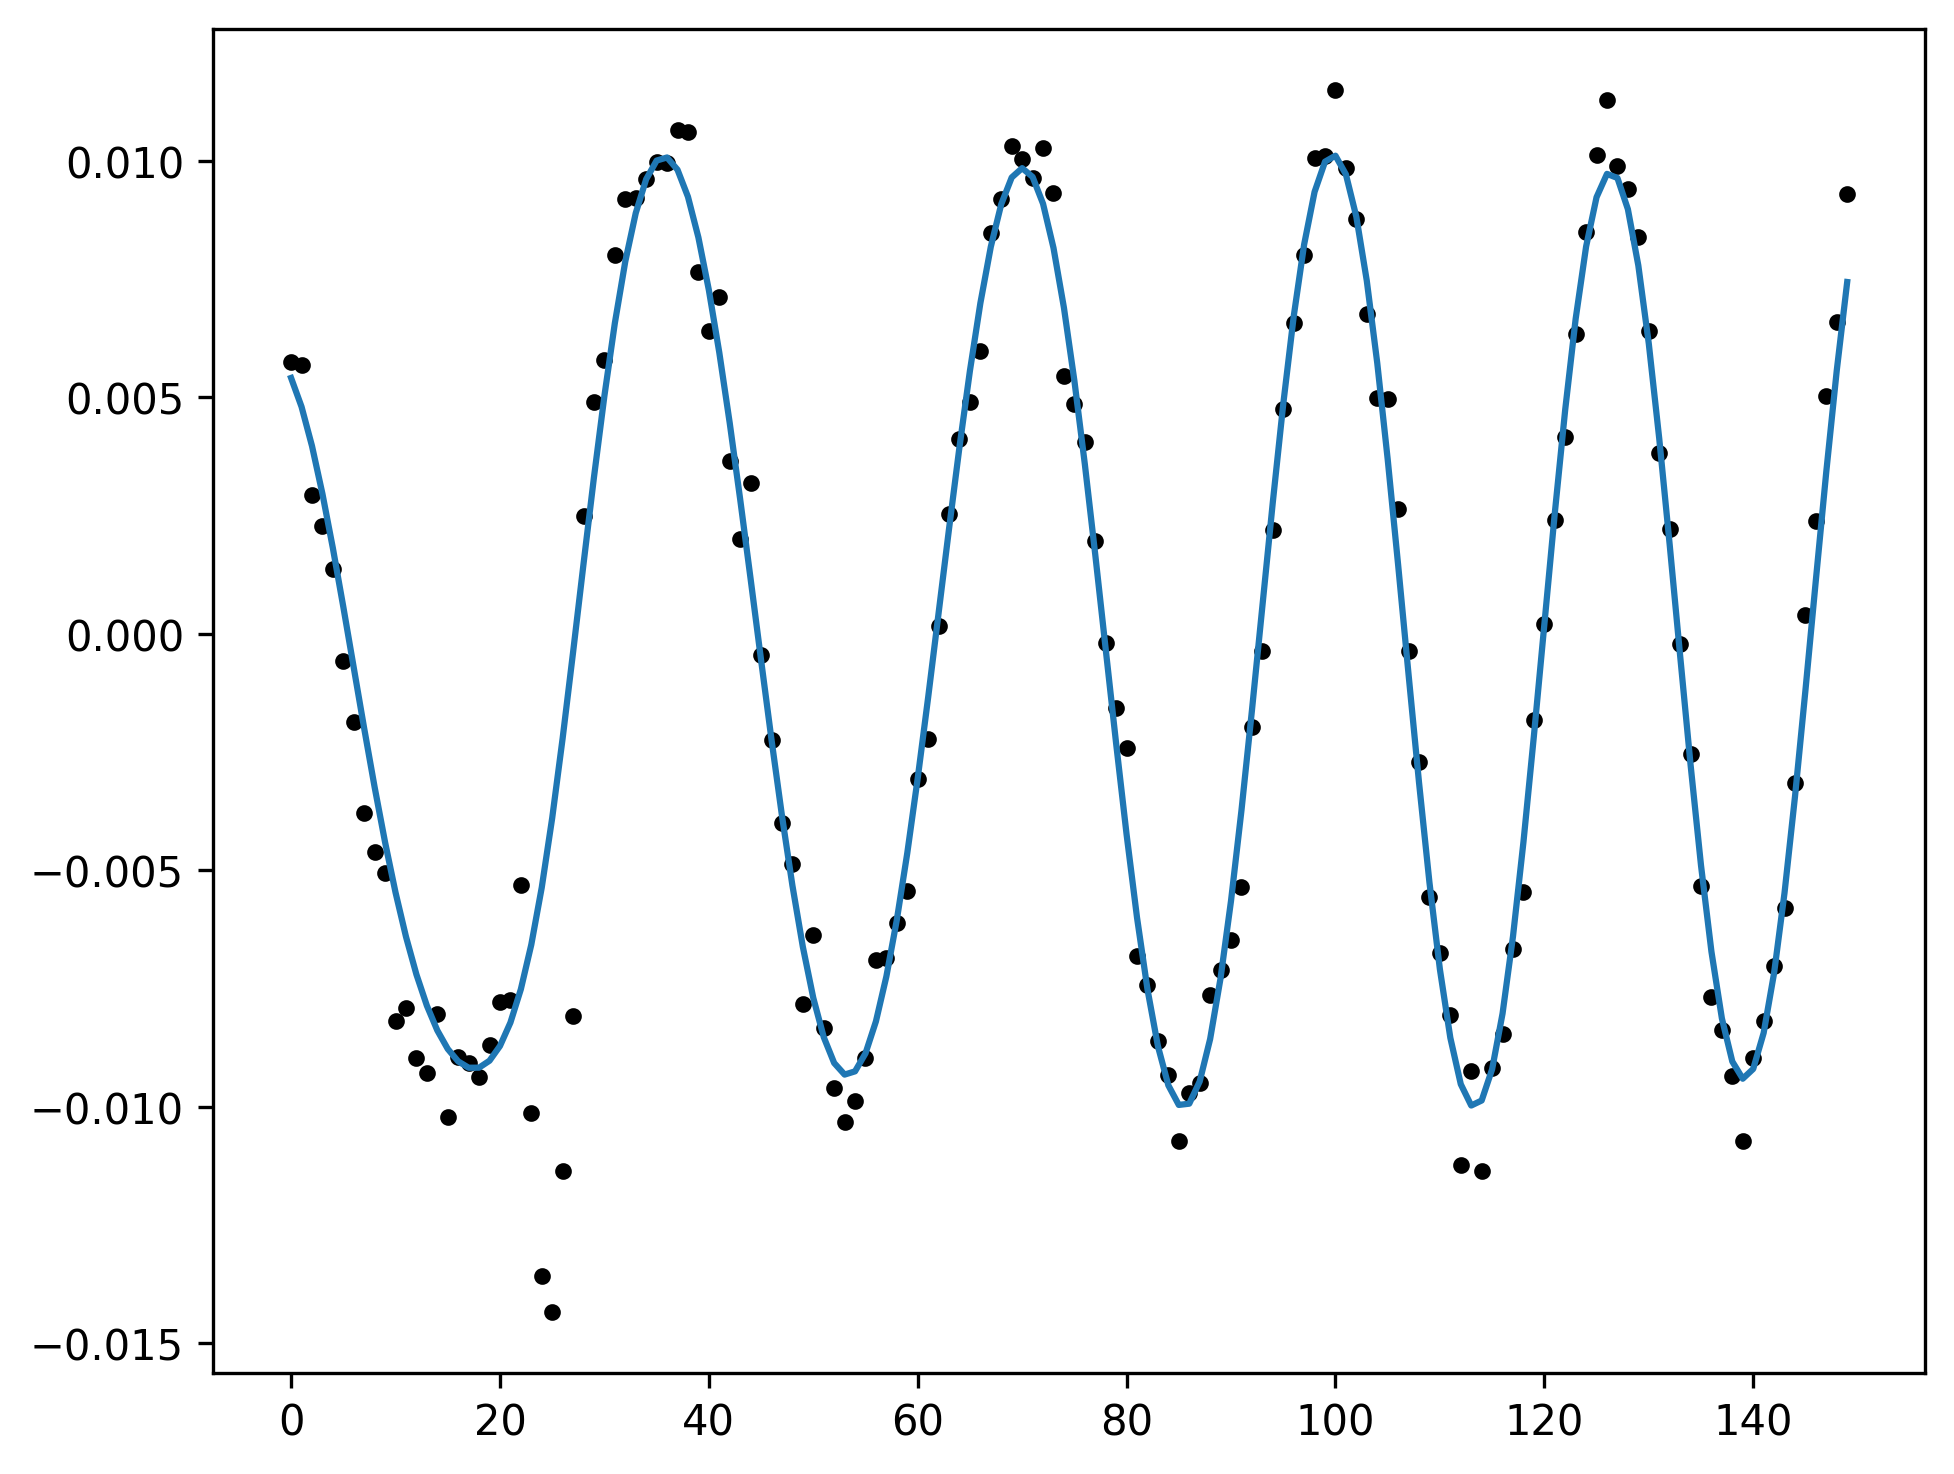

In [209]:
plt.plot(p.data.flux[0], 'k.')
plt.plot(mu)

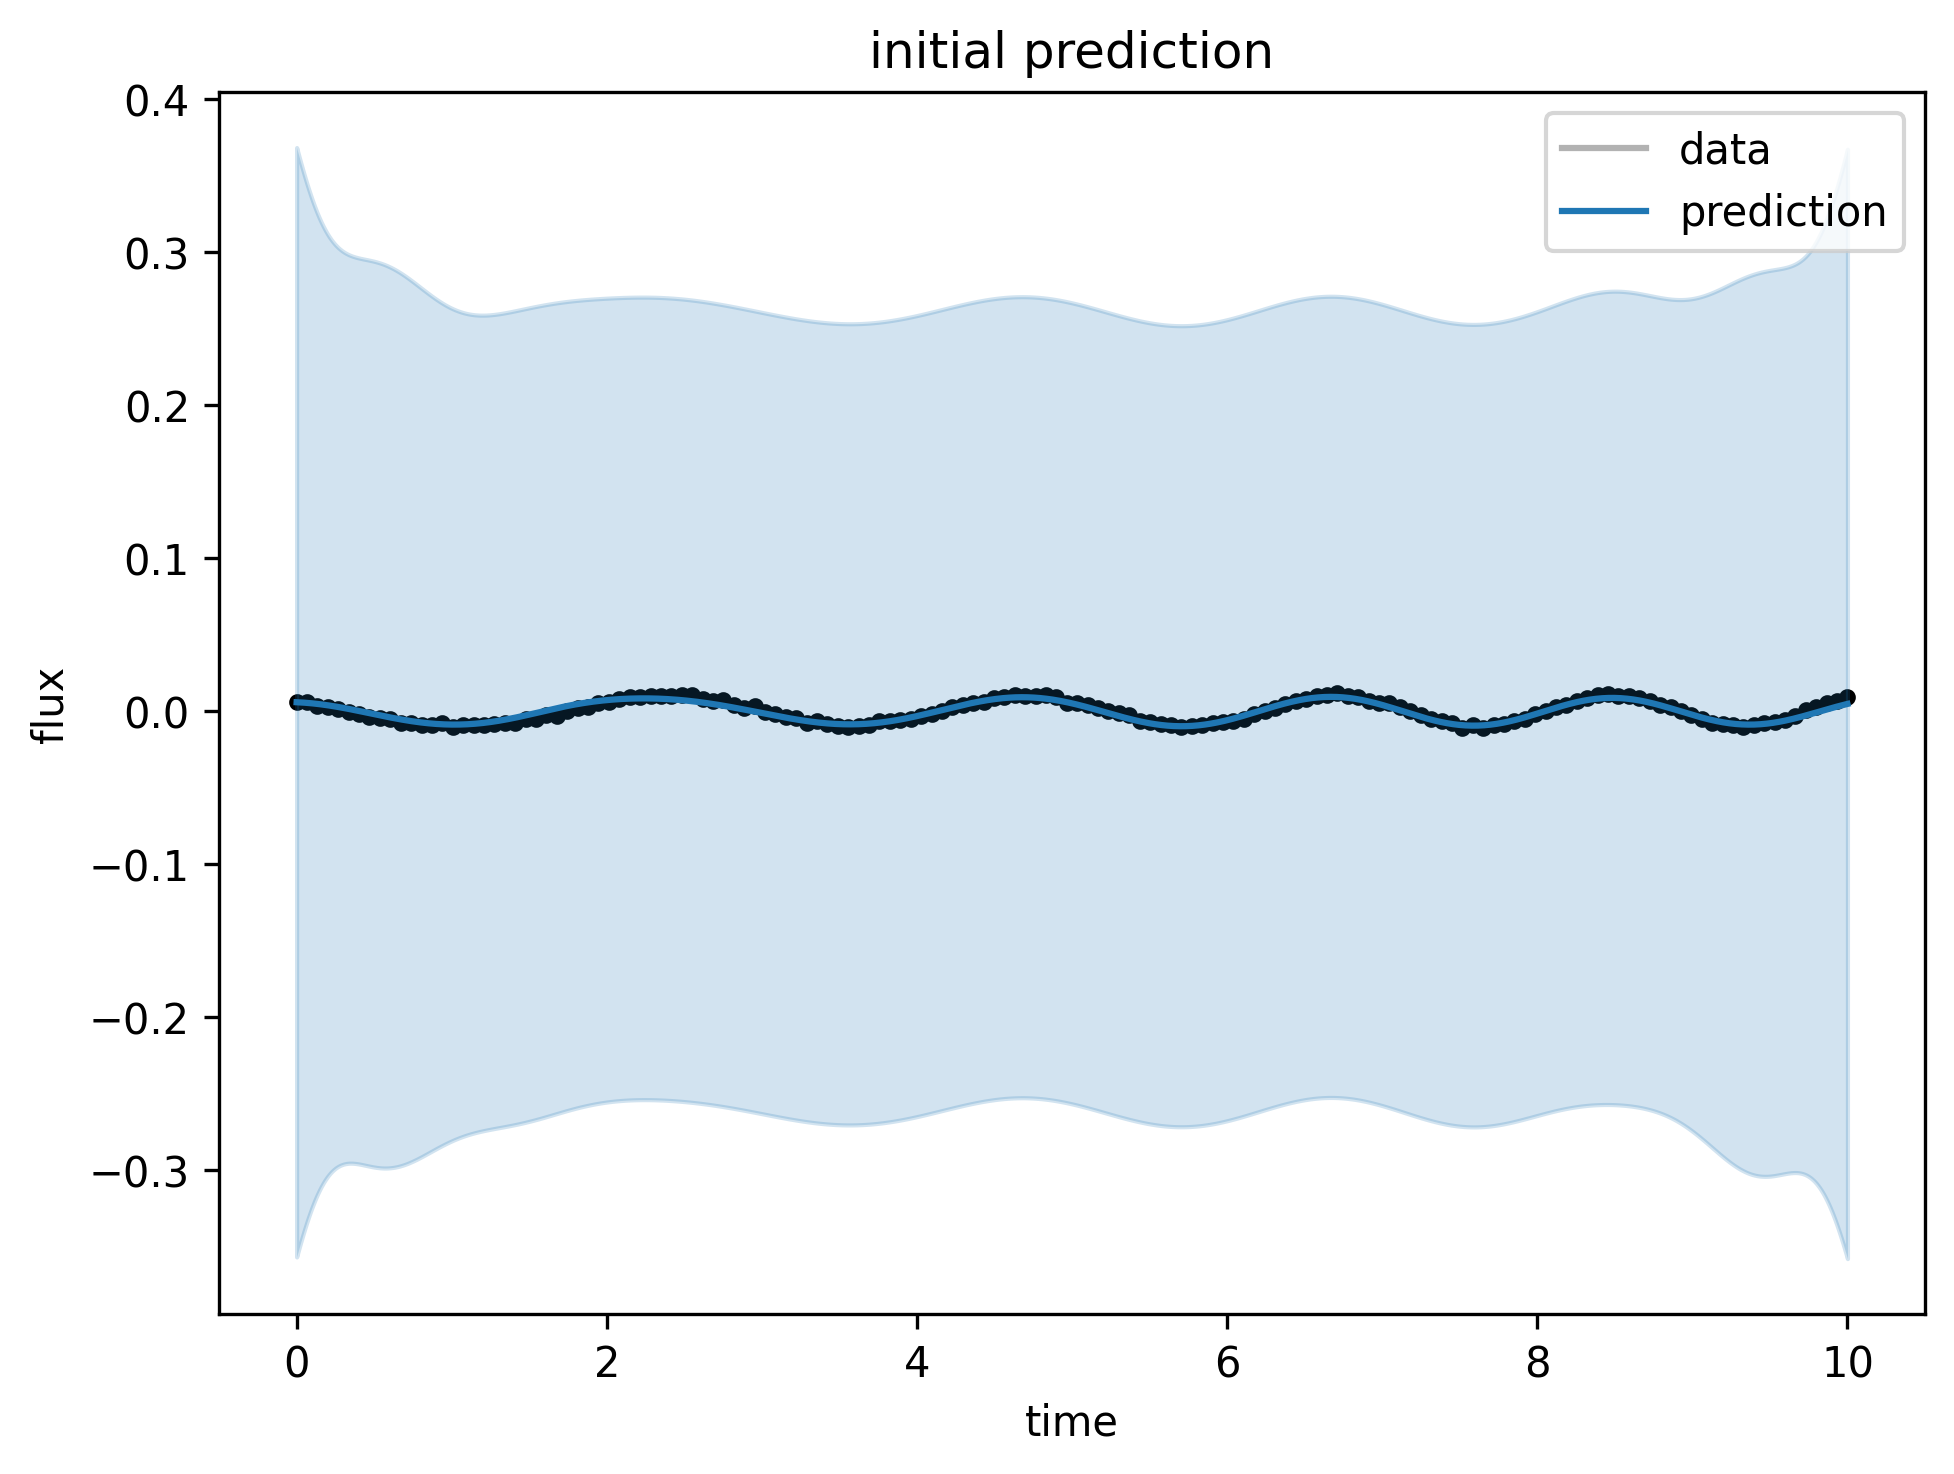

In [28]:
plt.title("initial prediction")
p.plot_prediction(p.gp[0])

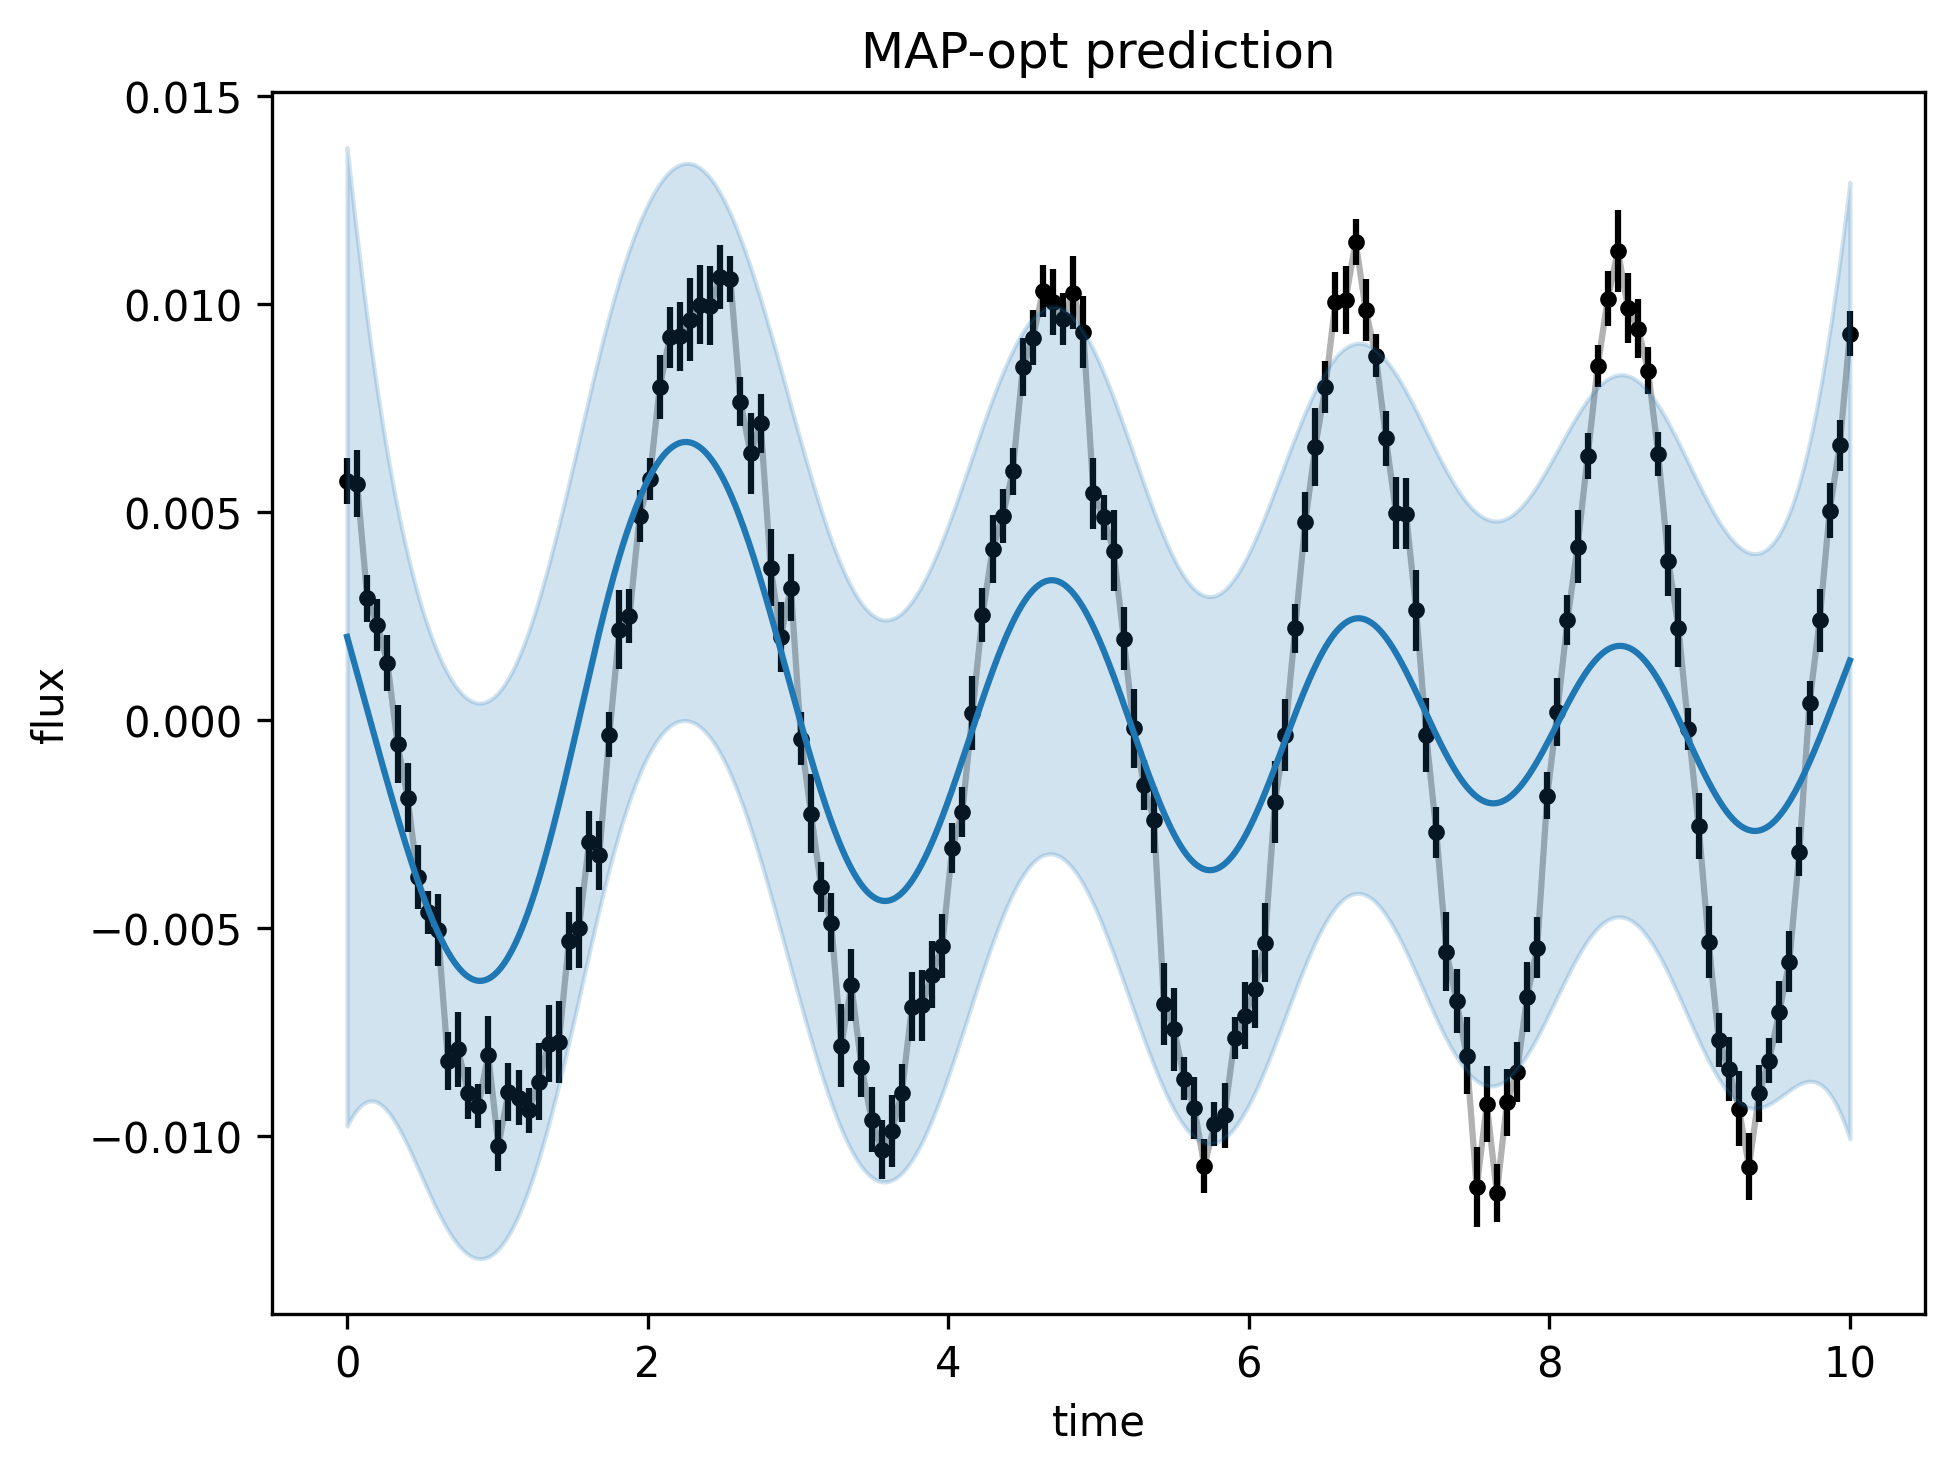

In [29]:
plt.title("MAP-opt prediction")
p.plot_prediction(p.generate_gp_model_from_params(params=opt), plot_var=True, legend=False)

In [485]:
# from scipy.optimize import minimize

# def set_params(params, gp):
#     gp.mean = params[0]
#     theta = np.exp(params[1:])
#     gp.kernel = terms.SHOTerm(sigma=theta[0], rho=theta[1], tau=theta[2])
#     gp.compute(t, diag=yerr**2 + theta[3], quiet=True)
#     return gp

# def neg_log_like(params, gp):
#     gp = set_params(params, gp)
#     return -gp.log_likelihood(y)

with pm.Model() as pmmodel:
    # Quasi-periodic term
    kernel = terms.SHOTerm(sigma=pm.Normal('sigma', mu=1.0, sd=2), 
                           rho=pm.Normal('rho', mu=2.0, sd=2), 
                           tau=pm.Normal('tau', mu=10.0, sd=2))
    
    # Setup the GP
    gp = GaussianProcess(kernel, mean=0.0)
    gp.compute(t=t, yerr=p.data.uncertainty[0])

    # initial_params = [0.0, 1.0, 2.0, 10.0, np.log(0.01)]
    # soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
    # opt_gp = set_params(soln.x, gp)
    # soln

    opt = pmx.optimize()
    opt

    
    # mu, variance = gp.predict(y=p.data.flux[0], t=t, return_var=True)
    # sigma = np.sqrt(variance)
    # plt.plot(p.data.time, p.data.flux[0],'k.')
    # plt.plot(t, mu.eval(), label="prediction")
    # plt.fill_between(t, (mu - sigma).eval(), (mu + sigma).eval(), color="C0", alpha=0.2)

optimizing logp for variables: [tau, rho, sigma]


message: Optimization terminated successfully.
logp: -4.836257141293855 -> -4.836257141293855


In [486]:
opt

{'sigma': array(1.), 'rho': array(2.), 'tau': array(10.)}

In [323]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(sampling_method=pmx.sample, start=opt, tune=2000, draws=4000, chains=4, cores=4, return_inferencedata=False)

Sampling model using the <function sample at 0x293f195e0> method


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_radius, transit_impact_parameter, transit_epoch, log_jitter, periodic_tau, periodic_rho, periodic_sigma]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 273 seconds.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
There were 229 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


                                   mean        sd    hdi_16%    hdi_84%  \
periodic_sigma[0]              0.008450  0.001355   0.006837   0.009341   
periodic_sigma[1]              0.008450  0.001362   0.006811   0.009279   
periodic_sigma[2]              0.008430  0.001345   0.006968   0.009432   
periodic_sigma[3]              0.008427  0.001326   0.006866   0.009326   
periodic_sigma[4]              0.008439  0.001340   0.006929   0.009390   
periodic_rho[0]                1.869783  0.080962   1.778976   1.936259   
periodic_tau[0]                1.499059  0.407749   1.036669   1.681765   
log_jitter                   -18.095668  0.749267 -18.700139 -17.279550   
transit_radius_ratio[0]        0.090588  0.034630   0.052290   0.122617   
transit_radius_ratio[1]        0.090937  0.034287   0.053123   0.122826   
transit_radius_ratio[2]        0.091012  0.034414   0.056642   0.125810   
transit_radius_ratio[3]        0.090947  0.034166   0.054623   0.123168   
transit_radius_ratio[4]  

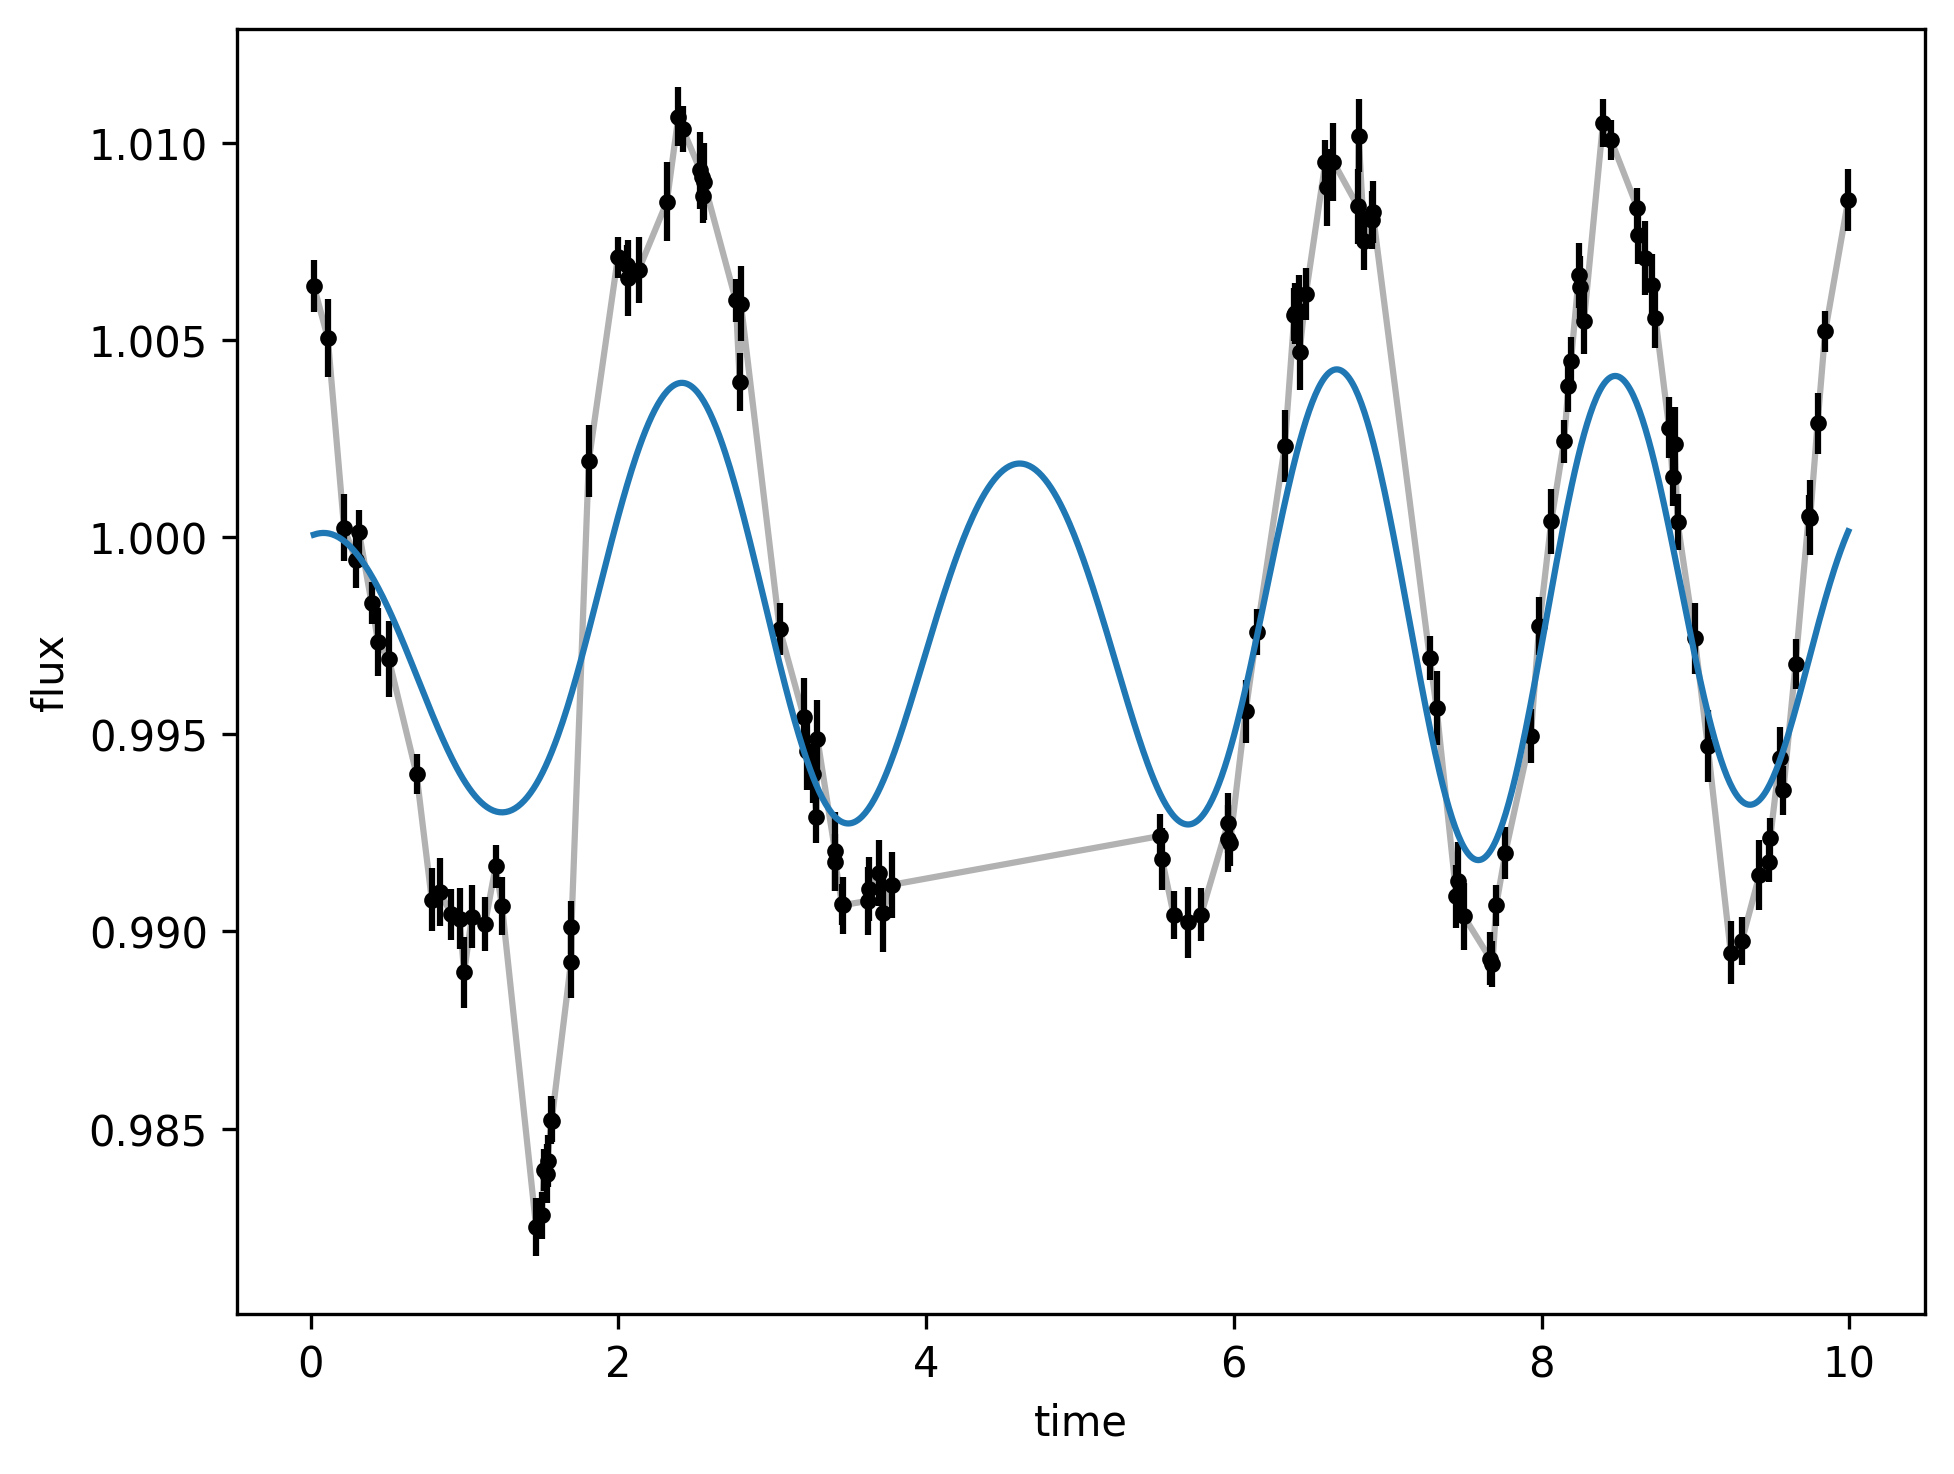

In [327]:
p.plot_traces(num_traces=1, i=0)

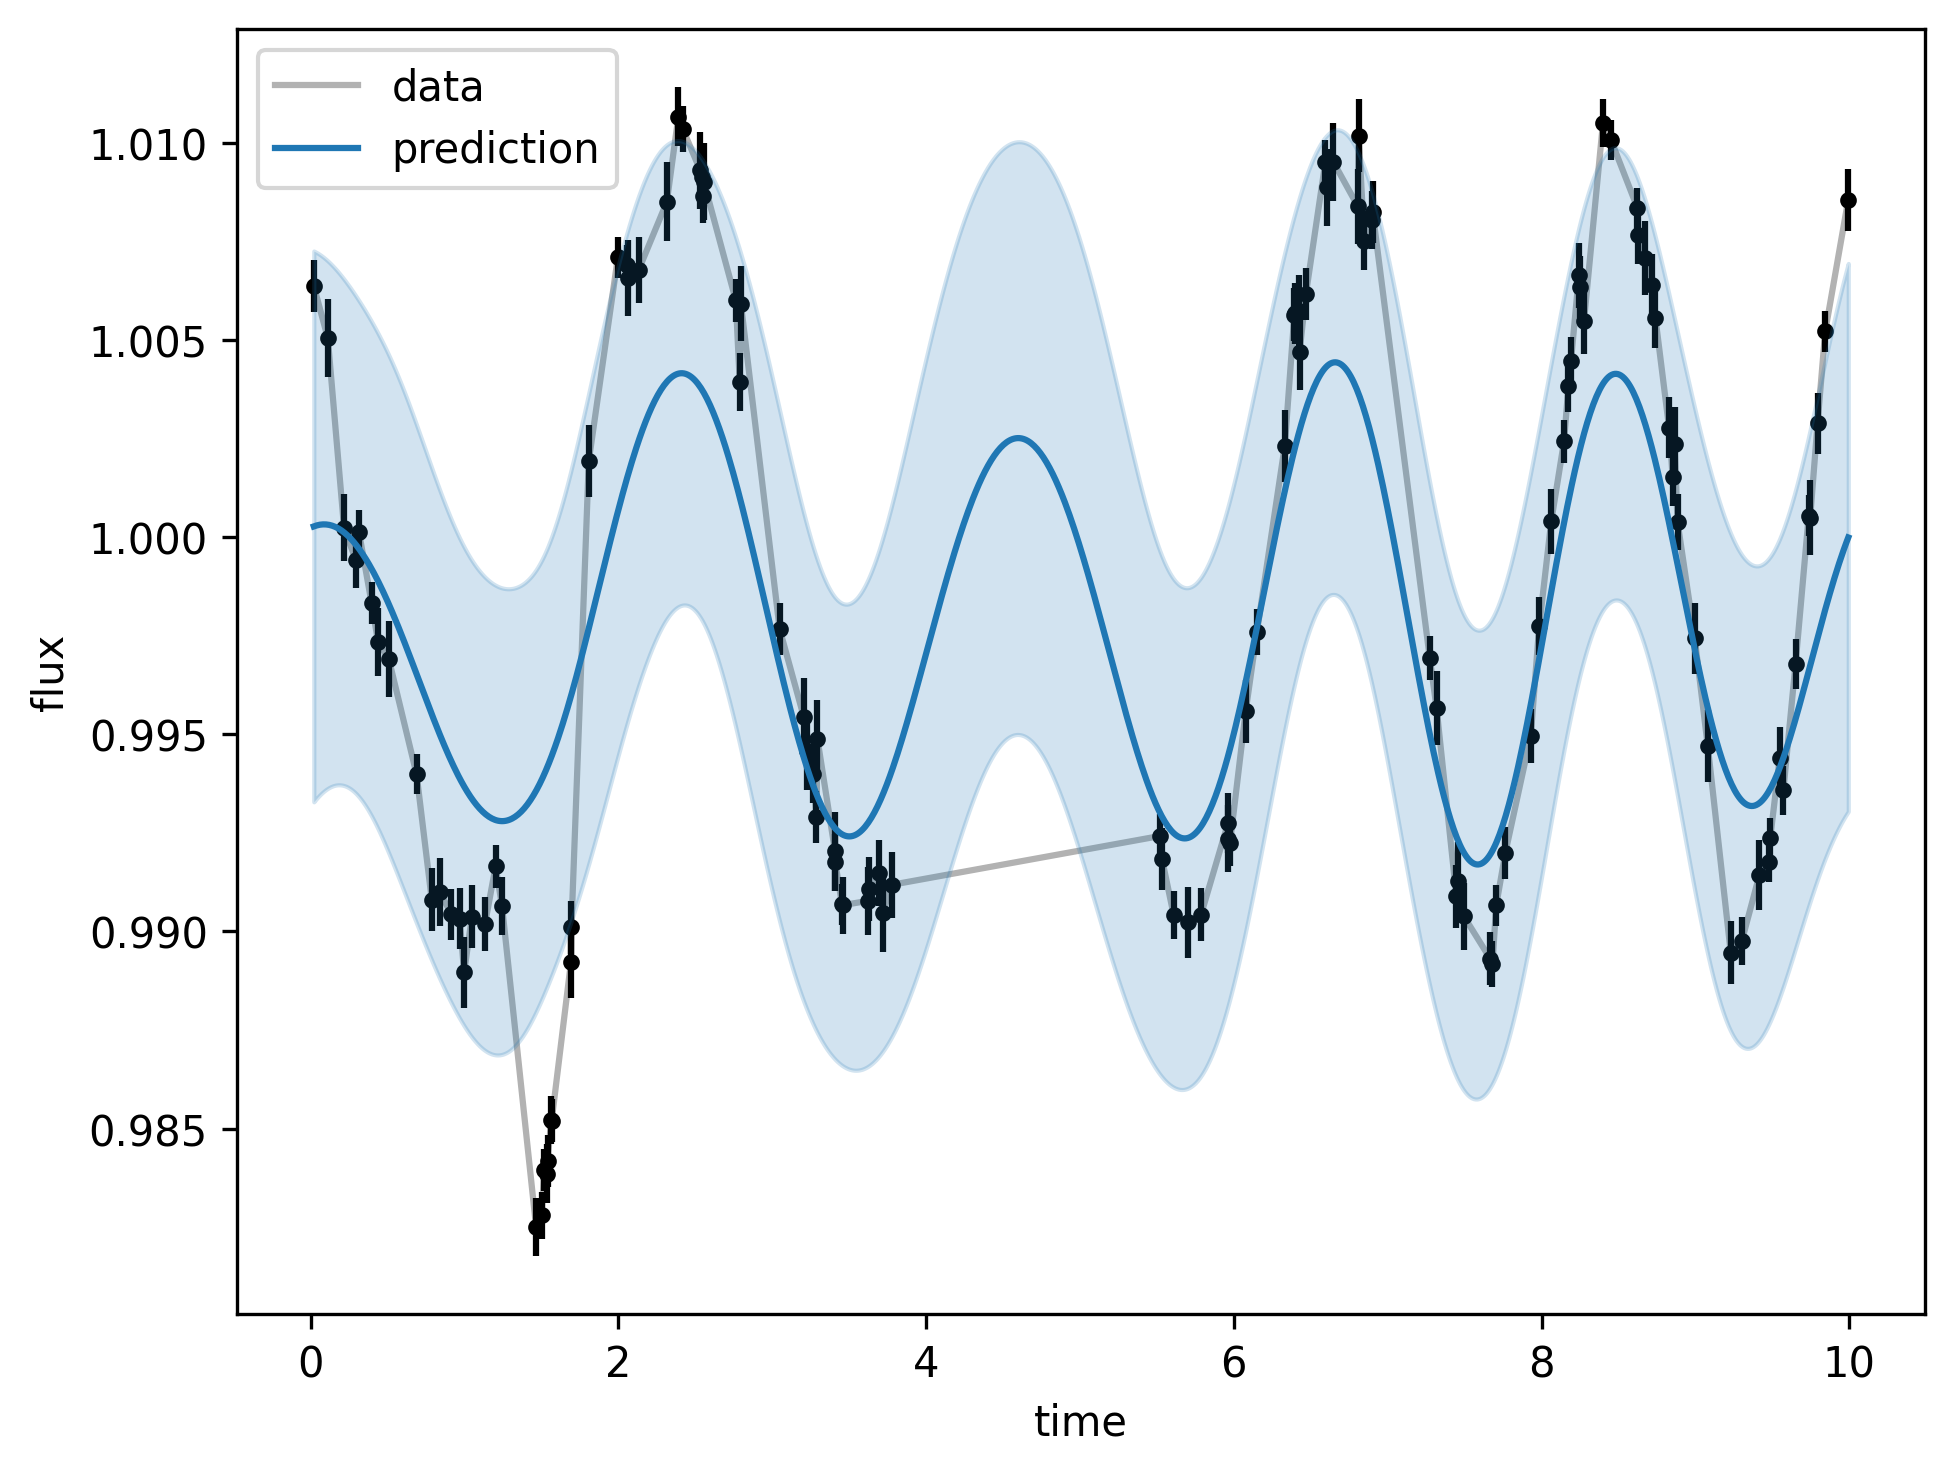

In [329]:
# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3,label="truth")
gp = p.generate_gp_model_from_params(p.summary['mean'])#new_results)
p.plot_prediction(gp)

In [79]:
p.plot_model()

Error applying get_model to <chromatic GP model 'periodic', with sho kernel 🌈>: name 'y' is not defined


IndexError: list index out of range